In [ ]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. Đọc file dữ liệu chứng khoán XOM
df_input = pd.read_csv('/content/drive/MyDrive/StockData/XOM.csv')

# 3. Đọc file dữ liệu trên tập dữ liệu dùng làm biến ngoại sinh (exogenous)
df_exo = pd.read_csv('/content/drive/MyDrive/StockData/DCOILWTICO.csv')

In [ ]:
# Đổi tên các cột DATE và DCOILWTICO
df_exo = df_exo.rename(columns={'DATE': 'Date', 'DCOILWTICO': 'WTI Price'})

# Chỉ lưu giữ các dòng trong df_exo có mà df_xom cũng có dựa trên cột ngày
df_exo = df_exo[df_exo['Date'].isin(df_input['Date'])]

# Thay thế các ô có giá trị '.' bằng NaN
df_exo.replace('.', np.nan, inplace=True)

# Chuyển đổi kiểu dữ liệu của cột 'WTI Price' thành float64
df_exo['WTI Price'] = df_exo['WTI Price'].astype(float)

# Tính giá trị trung bình của cột 'WTI Price'
mean_value = df_exo['WTI Price'].mean()

# Thay thế các NaN bằng giá trị trung bình
df_exo['WTI Price'].fillna(mean_value, inplace=True)

In [ ]:
df = pd.merge(df_input, df_exo, on='Date')
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,WTI Price
0,2018-01-02,83.820000,85.199997,83.660004,85.029999,64.879845,11469300,60.37
1,2018-01-03,85.160004,86.970001,84.820000,86.699997,66.154083,13957700,61.61
2,2018-01-04,86.790001,87.220001,86.430000,86.820000,66.245667,10863000,61.98
3,2018-01-05,86.750000,86.879997,85.709999,86.750000,66.192230,11047600,61.49
4,2018-01-08,86.699997,87.150002,86.599998,87.139999,66.489830,10927100,61.73
5,2018-01-09,86.940002,87.150002,86.650002,86.769997,66.207489,8131600,62.92
6,2018-01-10,87.000000,87.190002,85.980003,86.080002,65.681007,10822300,63.60
7,2018-01-11,86.360001,87.370003,85.930000,86.930000,66.329590,14366000,63.81
8,2018-01-12,87.199997,87.989998,87.180000,87.519997,66.779762,9834500,64.22
9,2018-01-16,87.739998,87.760002,86.599998,86.970001,66.360107,10882800,63.82


In [ ]:
# 4. Chia train test validate theo tỉ lệ 7:1:2
df = df[['Close', 'WTI Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print(len(train_data))
print(len(test_data))
print(len(val_data))

935
267
135


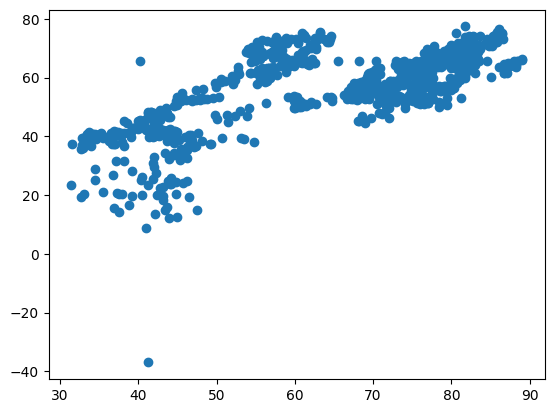

In [ ]:
exo_arr = np.array(train_data['WTI Price'])
data_arr = np.array(train_data['Close'])
# vẽ biểu đồ scatter plot để xem sự tương quan giữa giá cổ phiếu XOM và giá trị biến ngoại sinh
plt.scatter(x = data_arr, y = exo_arr)
plt.show()

In [ ]:
# Tìm hệ số tương quan giữa 2 cột Close và giá trị biến ngoại sinh
correlation = np.corrcoef(data_arr, exo_arr)[0, 1]

# In kết quả
print("Hệ số tương quan: ", correlation)

Hệ số tương quan:  0.7005344403175221


In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Operation cancelled by user


In [ ]:
# 3. Quá trình Training
train_exo = train_data[["WTI Price"]]

# Sử dụng auto_arima kèm biến ngoại sinh tìm ra model tốt nhất
from pmdarima.arima import auto_arima
model = auto_arima(train_data['Close'],
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      exogenous= train_exo)

# Gán các giá trị p, d, q vào các biến tương ứng
p = model.order[0]
d = model.order[1]
q = model.order[2]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2881.033, Time=4.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2883.570, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2885.565, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2885.566, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2882.318, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2887.643, Time=1.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2887.785, Time=2.90 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2888.412, Time=7.97 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=10.37 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2887.160, Time=2.54 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2889.160, Time=5.66 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2889.382, Time=1.12 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2886.044, Time=6.27 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2879.813, Time=2.16 sec
 ARIMA(1,1,2)(0,0,0)[0]             :

In [ ]:
# Khởi tạo mô hình ARIMAX với order=(p, d, q) và khai báo biến ngoại sinh
model= SARIMAX(train_data['Close'],
 exog=train_exo,
 order=(p,d,q),
 enforce_invertibility=False, enforce_stationarity=False)

# Fit mô hình bằng dữ liệu huấn luyện để tìm ra các giá trị tối ưu cho các tham số của mô hình
model = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
test_exo = test_data[['WTI Price']]
y_pred = model.forecast(steps=len(y_test), exog=test_exo)

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
val_exo = val_data[['WTI Price']]
y_pred_val =  model.forecast(steps=len(y_val), exog=val_exo)

In [ ]:
# 6. Đánh giá độ chính xác thuật toán bằng RMSE
# Tính MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAPE và MDA
valid_rmse = np.sqrt(np.mean((y_val- y_pred_val) ** 2))
test_rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))

valid_mape = calculate_mape(y_val, y_pred_val)
test_mape = calculate_mape(y_test, y_pred)

valid_mda = calculate_mda(np.squeeze(y_val), np.squeeze(y_pred_val))
test_mda = calculate_mda(np.squeeze(y_test), np.squeeze(y_pred))

# In kết quả
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
print('Validation MDA:', valid_mda)
print('Testing MDA:', test_mda)

Validation RMSE: 54.83556967712389
Testing RMSE: 26.702811517092666
Validation MAPE: 49.50613514461575
Testing MAPE: 27.55830282201879
Validation MDA: 68.65671641791045
Testing MDA: 74.81203007518798


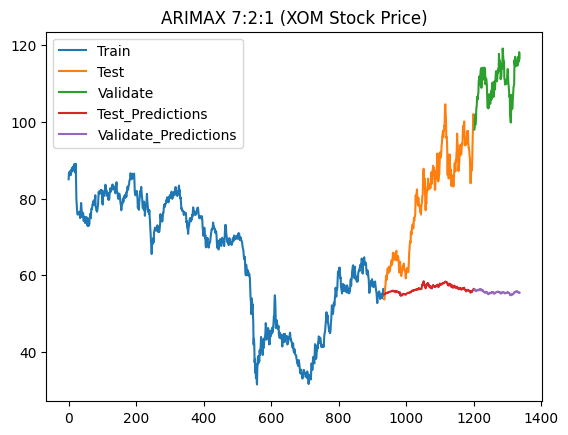

In [ ]:
# 7.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.legend(['Train', 'ActualTest', 'PredictedTest','ActualValidate', 'PredictedValidate'])
plt.title('ARIMAX 7:2:1 (XOM Stock Price)')
plt.show()